## **1. Introdução**

Tendo em vista a influência que os K-Dramas, novelas coreanas, tem ao redor do mundo, esse projeto tem como intuito prever a média da avaliação dos usuários tendo como base vários elementos da obra. O conjunto de dados utilizado consiste na lista dos 100 *doramas* mais assistidos pelo público do site *MyDramaList*, uma rede social para acompanhar lançamentos de filmes e séries asiáticas.

#### **Descrição e classificação das variáveis:**

1. **Qualitativas nominais:**
  * **Name:** O título da obra.
  * **Aired On:** O(s) dia(s) da semana em que os episódios eram lançados.
  * **Genres:** Os principais gêneros da obra.
  * **Tags:** As principais dinâmicas e o estilo da obra.
  * **Main Actors:** Os atores principais, com maior aparição.

2. **Quantitativas discretas:**
  * **Year:** O ano de lançamento.
  * **Episodes:** O número de episódios.

3. **Quantitativas contínuas:**
  * **Ep. Duration:** A duração do episódio em horas.
  * **Watchers:** A quantidade de pessoas que assistiram. Também é utilizado para ranquear a popularidade.
  * **Rating:** É a média das avaliações, servindo como um parâmetro para entender a recepção do público para aquele conteúdo. É a variável que se dependente desse trabalho, seu foco de estudo.


## **2. Pré-processamento dos dados**

### **2.1. Inicialização do conjunto:**

In [34]:
!pip install pgmpy

In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import networkx as nx
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.inference import VariableElimination
from pgmpy.factors.discrete import TabularCPD
from pgmpy.estimators import BayesianEstimator


drama = pd.read_csv('https://raw.githubusercontent.com/VitoriaPontes/AmostragemTabelasKDrama/refs/heads/main/top%20100%20most%20popular%20k-dramas.csv')
drama.info()
drama.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Name          100 non-null    object 
 1   Year          100 non-null    int64  
 2   Rating        100 non-null    float64
 3   Watchers      100 non-null    object 
 4   Episodes      100 non-null    int64  
 5   Ep. Duration  100 non-null    object 
 6   Aired On      100 non-null    object 
 7   Genres        100 non-null    object 
 8   Tags          100 non-null    object 
 9   Main Actors   100 non-null    object 
dtypes: float64(1), int64(2), object(7)
memory usage: 7.9+ KB


,Name,Year,Rating,Watchers,Episodes,Ep. Duration,Aired On,Genres,Tags,Main Actors
0,Goblin,2016,8.8,"254,985",16,01:22,"Friday, Saturday","Comedy,Romance,Fantasy,Melodrama","Older Man/Younger Woman,Interspecies Romance,D...","Gong Yoo,Kim Go Eun,Lee Dong Wook,Yoo In Na,Yo..."
1,Strong Woman Do Bong Soon,2016,8.7,"239,773",16,01:07,"Friday, Saturday","Action,Comedy,Romance,Supernatural","Superhuman Strenght,Love Triangle,Nice Male Le...","Park Bo Young,Park Hyung Sik,Kim Ji Soo"
2,It's Okay to Not Be Okay,2020,8.9,"215,957",16,01:15,"Saturday, Sunday","Psychological,Comedy,Romance,Drama","Independent Female Lead,Possessive Female Lead...","Kim Soo Hyun,Seo Yea Ji,Oh Jung Se"
3,Descendants of the Sun,2016,8.6,"213,187",16,01:00,"Wednesday, Thursday","Action,Comedy,Romance,Supernatural","Military,Bromance,Multiple Couples,Hardworking...","Song Joong Ki,Song Hye Kyo,Jin Goo,Kim Ji Won"
4,What's Wrong with Secretary Kim,2018,8.5,"212,766",16,01:09,"Wednesday, Thursday","Business,Comedy,Romance","Boss-Employee Relationship,Rich Male Lead,Adap...","Park Min Young,Park Seo Joon"


O dataset **drama** possui 10 variáveis e 100 valores não-nulos, sendo necessário algumas mudanças iniciais para melhor utilização dos dados.

### **2.2. Ajustando o conjunto**

Visualizando as informações e as informações da tabela, é possível perceber que a variável **Watchers** está incorretamente atribuida como *object*, quando deveria ser *int*. Além disso, as variáveis **Genres**, **Tags** e **Main Actors** devem ser transformadas em listas de objetos com o intuito de visualizar melhor cada elemento.

In [36]:
drama['Watchers'] = drama['Watchers'].str.replace(',', '')
drama['Watchers'] = drama['Watchers'].astype(int)
drama['Genres'] = drama['Genres'].str.split(',')
drama['Tags'] = drama['Tags'].str.split(',')
drama['Main Actors'] = drama['Main Actors'].str.split(',')

In [37]:
drama.info()
drama.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Name          100 non-null    object 
 1   Year          100 non-null    int64  
 2   Rating        100 non-null    float64
 3   Watchers      100 non-null    int64  
 4   Episodes      100 non-null    int64  
 5   Ep. Duration  100 non-null    object 
 6   Aired On      100 non-null    object 
 7   Genres        100 non-null    object 
 8   Tags          100 non-null    object 
 9   Main Actors   100 non-null    object 
dtypes: float64(1), int64(3), object(6)
memory usage: 7.9+ KB


,Name,Year,Rating,Watchers,Episodes,Ep. Duration,Aired On,Genres,Tags,Main Actors
0,Goblin,2016,8.8,254985,16,01:22,"Friday, Saturday","[Comedy, Romance, Fantasy, Melodrama]","[Older Man/Younger Woman, Interspecies Romance...","[Gong Yoo, Kim Go Eun, Lee Dong Wook, Yoo In N..."
1,Strong Woman Do Bong Soon,2016,8.7,239773,16,01:07,"Friday, Saturday","[Action, Comedy, Romance, Supernatural]","[Superhuman Strenght, Love Triangle, Nice Male...","[Park Bo Young, Park Hyung Sik, Kim Ji Soo]"
2,It's Okay to Not Be Okay,2020,8.9,215957,16,01:15,"Saturday, Sunday","[Psychological, Comedy, Romance, Drama]","[Independent Female Lead, Possessive Female Le...","[Kim Soo Hyun, Seo Yea Ji, Oh Jung Se]"
3,Descendants of the Sun,2016,8.6,213187,16,01:00,"Wednesday, Thursday","[Action, Comedy, Romance, Supernatural]","[Military, Bromance, Multiple Couples, Hardwor...","[Song Joong Ki, Song Hye Kyo, Jin Goo, Kim Ji ..."
4,What's Wrong with Secretary Kim,2018,8.5,212766,16,01:09,"Wednesday, Thursday","[Business, Comedy, Romance]","[Boss-Employee Relationship, Rich Male Lead, A...","[Park Min Young, Park Seo Joon]"


### **2.3. Transformando variáveis quantitativas em qualitativas**

In [38]:
print(drama['Watchers'].min())
print(drama['Watchers'].max())

82611
254985


Agora com os valores de mínimo e máximo poderemos construir os intervalos para a variável Watchers. Para a quantidade de intervalos é usado √n, onde n é o número de valores que existem. Como são 100, o número de intervalos será 10. Para encontrar a amplitude desse intervalo, usamos: (max - min)/10 = (254985 - 82611)/10 = 17237,4. Como não existem valores quebrados para essa variável, irei arredondar para o próximo número inteiro na criação dos intervalos.

Substituindo os valores pelo intervalo na tabela:

In [39]:
bins = [82611, 99849, 117086, 134324, 151561, 168798, 186036, 203273, 220511, 237748, 254985]
labels = ['82.611 a 99.849', '99.850 a 117.086', '117.087 a 134.324', '134.325 a 151.561', '151.562 a 168.798', '168.799 a 186.036', '186.037 a 203.273', '203.274 a 220.511', '220.512 a 237.748', '237.749 a 254.985']
drama['Watchers'] = pd.cut(drama['Watchers'], bins = bins, labels = labels, include_lowest = True)

Para a variável Ep. Duration, por se tratar do tempo em horas, é mais conveniente para a interpretação que seja dividido em intervalos comuns de tempo. Nesse caso, serão utilizados intervalos com diferença de 10 minutos cada. Por fim, para que isso seja possível, é preciso primeiro converter de horas para minutos, sendo capaz de realizar operações com os números inteiros.

In [40]:
def conversor(horario):
    h, m = map(int, horario.split(":"))
    return h * 60 + m

drama['Ep. Duration'] = drama['Ep. Duration'].apply(conversor)

In [41]:
print(drama['Ep. Duration'].min())
print(drama['Ep. Duration'].max())

30
95


In [42]:
bins = [30, 40, 50, 60, 70, 80, 95]
labels = ['00:30 a 00:40', '00:41 a 00:50', '00:51 a 00:60', '00:61 a 00:70', '00:71 a 00:80', '00:81 a 00:95']
drama['Ep. Duration'] = pd.cut(drama['Ep. Duration'], bins = bins, labels = labels, include_lowest = True)

Por último, a variável Rating será convertida em intervalos com diferença de 0.5 na avaliação, para facilitar a interpretação.

In [43]:
print(drama['Rating'].min())
print(drama['Rating'].max())

7.1
9.2


In [44]:
bins = [7.0, 7.5, 8.0, 8.5, 9.0, 10]
labels = ['7 a 7.5', '7.6 a 8', '8.1 a 8.5', '8.6 a 9', '9.1 a 10']
drama['Rating'] = pd.cut(drama['Rating'], bins = bins, labels = labels, include_lowest = True)

In [45]:
drama.head()

,Name,Year,Rating,Watchers,Episodes,Ep. Duration,Aired On,Genres,Tags,Main Actors
0,Goblin,2016,8.6 a 9,237.749 a 254.985,16,00:81 a 00:95,"Friday, Saturday","[Comedy, Romance, Fantasy, Melodrama]","[Older Man/Younger Woman, Interspecies Romance...","[Gong Yoo, Kim Go Eun, Lee Dong Wook, Yoo In N..."
1,Strong Woman Do Bong Soon,2016,8.6 a 9,237.749 a 254.985,16,00:61 a 00:70,"Friday, Saturday","[Action, Comedy, Romance, Supernatural]","[Superhuman Strenght, Love Triangle, Nice Male...","[Park Bo Young, Park Hyung Sik, Kim Ji Soo]"
2,It's Okay to Not Be Okay,2020,8.6 a 9,203.274 a 220.511,16,00:71 a 00:80,"Saturday, Sunday","[Psychological, Comedy, Romance, Drama]","[Independent Female Lead, Possessive Female Le...","[Kim Soo Hyun, Seo Yea Ji, Oh Jung Se]"
3,Descendants of the Sun,2016,8.6 a 9,203.274 a 220.511,16,00:51 a 00:60,"Wednesday, Thursday","[Action, Comedy, Romance, Supernatural]","[Military, Bromance, Multiple Couples, Hardwor...","[Song Joong Ki, Song Hye Kyo, Jin Goo, Kim Ji ..."
4,What's Wrong with Secretary Kim,2018,8.1 a 8.5,203.274 a 220.511,16,00:61 a 00:70,"Wednesday, Thursday","[Business, Comedy, Romance]","[Boss-Employee Relationship, Rich Male Lead, A...","[Park Min Young, Park Seo Joon]"


Agora as variáveis quantitativas contínuas foram todas transformadas em intervalos, variáveis qualitativas ordinais.

### **2.4. One-Hot Encoding**

Considerando a quantidade de atores e como suas aparições são baixas considerando o dataset, essa coluna será removida pois não é tão relevante para a estimação.

In [46]:
actors = drama['Main Actors'].explode()
actors.value_counts()

,count
Main Actors,
Lee Jong Suk,6
Park Seo Joon,6
Nam Joo Hyuk,5
Bae Suzy,5
Lee Min Ho,5
...,...
Ham Eun Jung,1
Jang Woo Young,1
Kim Ha Neul,1


In [47]:
drama.drop(columns=['Main Actors'], inplace=True)

Devido a grande quantidade de valores para **Genres**, será escolhido apenas os 15 mais frequentes para o One-Hot Encoding.

In [48]:
genres = drama['Genres'].explode()
genres_top15 = genres.value_counts().head(15).index.tolist()
print(genres_top15)

['Romance', 'Comedy', 'Drama', 'Fantasy', 'Thriller', 'Life', 'Action', 'Melodrama', 'Mystery', 'Youth', 'Supernatural', 'Psychological', 'Horror', 'Business', 'Crime']


In [49]:
for genre in genres_top15:
    drama[f'{genre}'] = drama['Genres'].apply(lambda x: int(genre in x))

drama.drop(columns=['Genres'], inplace=True)

Devido a grande quantidade de valores para **Tags**, será escolhido apenas os 20 mais frequentes para o One-Hot Encoding.

In [50]:
tags = drama['Tags'].explode()
tags_top20 = tags.value_counts().head(20).index.tolist()
print(tags_top20)

['Nice Male Lead', 'Love Triangle', 'Rich Male Lead', 'Hidden Identity', 'Bromance', 'Hardworking Female Lead', 'Death', 'Smart Male Lead', 'Smart Female Lead', 'Male Chases Female First', 'First Love', 'Trauma', 'Cohabitation', 'Character Development', 'Healing', 'Hardworking Male Lead', 'Adapted From A Webtoon', 'Boss-Employee Relationship', 'School Bullying', 'High School']


In [51]:
for tag in tags_top20:
    drama[f'{tag}'] = drama['Tags'].apply(lambda x: int(tag in x))

drama.drop(columns=['Tags'], inplace=True)

Agora visualizando o resultado final da tabela após usar o método One-Hot Encoding para as colunas **Genres** e **Tags**.

### **2.5. Qualitativa e Quantitativa**

Classificação das variáveis em qualitativas e quantitativas melhor otimização do código.

In [52]:
quali = []
quanti = []

for column in drama.columns:
    if drama[column].dtype == 'object' or drama[column].dtype == 'category':
        quali.append(column)
    else:
        quanti.append(column)

quali.remove('Name')

print(quali)
print(quanti)

['Rating', 'Watchers', 'Ep. Duration', 'Aired On']
['Year', 'Episodes', 'Romance', 'Comedy', 'Drama', 'Fantasy', 'Thriller', 'Life', 'Action', 'Melodrama', 'Mystery', 'Youth', 'Supernatural', 'Psychological', 'Horror', 'Business', 'Crime', 'Nice Male Lead', 'Love Triangle', 'Rich Male Lead', 'Hidden Identity', 'Bromance', 'Hardworking Female Lead', 'Death', 'Smart Male Lead', 'Smart Female Lead', 'Male Chases Female First', 'First Love', 'Trauma', 'Cohabitation', 'Character Development', 'Healing', 'Hardworking Male Lead', 'Adapted From A Webtoon', 'Boss-Employee Relationship', 'School Bullying', 'High School']


## **3. Análise Descritiva dos Dados**

In [53]:
drama.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 42 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   Name                        100 non-null    object  
 1   Year                        100 non-null    int64   
 2   Rating                      100 non-null    category
 3   Watchers                    100 non-null    category
 4   Episodes                    100 non-null    int64   
 5   Ep. Duration                100 non-null    category
 6   Aired On                    100 non-null    object  
 7   Romance                     100 non-null    int64   
 8   Comedy                      100 non-null    int64   
 9   Drama                       100 non-null    int64   
 10  Fantasy                     100 non-null    int64   
 11  Thriller                    100 non-null    int64   
 12  Life                        100 non-null    int64   
 13  Action               

### **3.1. Análise univariada qualitativa**

***ADICIONAR ORDEM NO GRÁFICO***

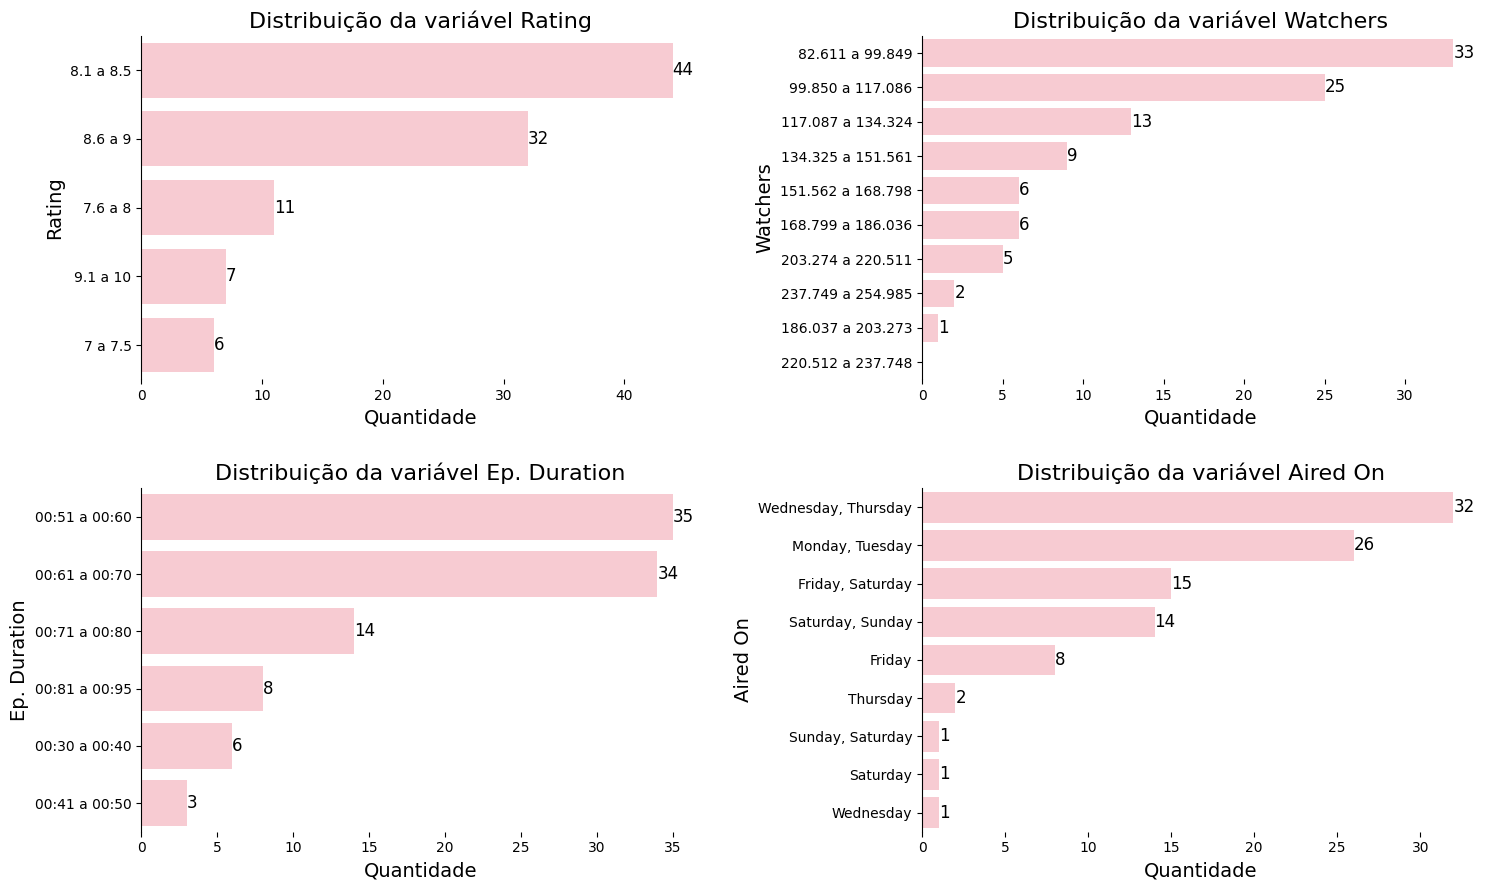

In [54]:
fig, axes = plt.subplots(figsize=(15, 9), ncols = 2, nrows = 2)
axes = axes.flatten()

for i, variavel in enumerate(quali):
    order = drama[variavel].value_counts().index
    # Criar a figura
    ax = sns.countplot(drama, y=variavel, ax=axes[i], order=order, alpha=.8, color='lightpink')
    ax.bar_label(ax.containers[0], fmt="%d", color="black", label_type="edge", fontsize=12)
    ax.set(title=f"Distribuição da variável {variavel}", xlabel = "Quantidade")
    ax.title.set_fontsize(16)
    ax.xaxis.label.set_fontsize(14)
    ax.yaxis.label.set_fontsize(14)

    for side in ["bottom", "top", "right"]:
        ax.spines[side].set_visible(False)
    ax.spines["left"].set_color("black")

plt.tight_layout(h_pad=2.5, w_pad=2.5)
plt.show()

A maior parte desse conjunto possui uma avaliação média de **8.1 a 8.5**, enquanto a minoria possui uma avaliação mais baixa — **7.1 a 7.5** — ou uma avalição muito alta — **9.1 a 10**.
A maioria está abaixo dos **100.000** espectadores da plataforma, o valor mais alto, de **237.749 a 254.985** possui apenas 2 K-Dramas.
Para a duração dos episódios, é mais comum que eles tenham entre **50 e 70 minutos**.
**Quarta e Quinta** e **Segunda e Terça** são os padrões de lançamentos que mais aparecem nessa lista.

### **3.2. Análise univariada quantitativa**

[]

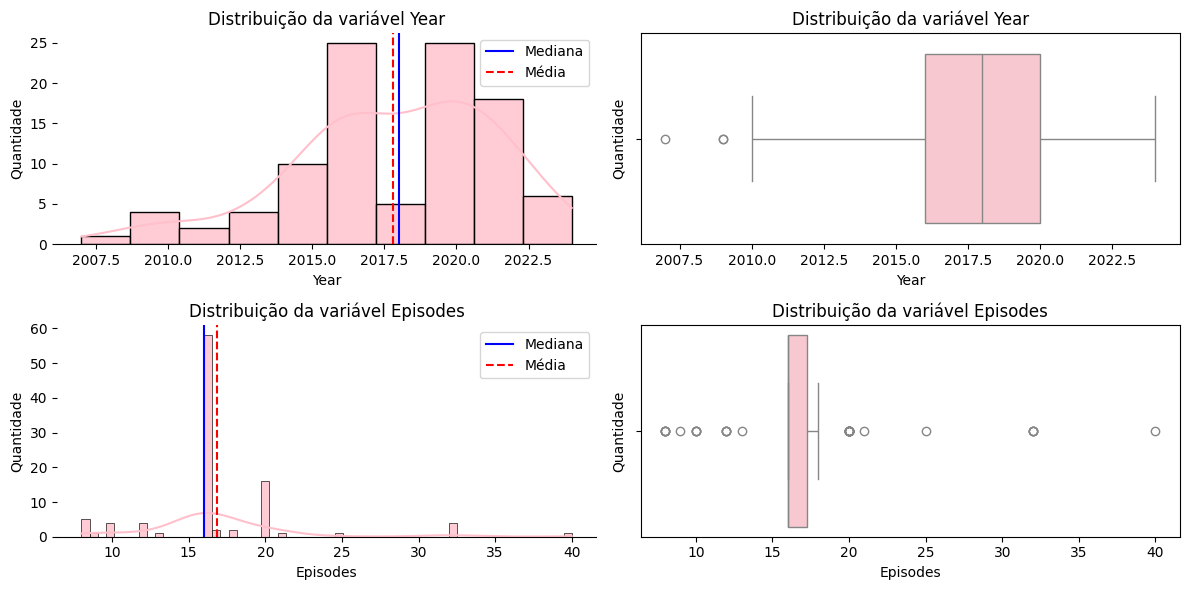

In [55]:
fig, axes = plt.subplots(figsize=(12, 6), ncols=2, nrows=2)

variaveis = ['Year', 'Episodes']
for i, variavel in enumerate(variaveis):
    ax = sns.histplot(data=drama, x=variavel, ax=axes[i, 0], kde=True, alpha=.8, color='pink')
    ax.axvline(drama[variavel].median(), color="blue", label="Mediana")
    ax.axvline(drama[variavel].mean(), color="red", linestyle="--", label="Média")
    ax.set(title=f"Distribuição da variável {variavel}", ylabel="Quantidade")
    ax.legend()
    ax.spines["bottom"].set_color("black")
    ax.grid(False, axis="x")
    for side in ["left", "top", "right"]:
        ax.spines[side].set_visible(False)
    ax = sns.boxplot(data=drama, x=variavel, ax=axes[i, 1], color='pink')
    ax.set(title=f"Distribuição da variável {variavel}", ylabel="Quantidade")
    ax.spines["bottom"].set_color("black")
    ax.grid(False)


plt.tight_layout(h_pad=8, w_pad=8)
plt.tight_layout()
plt.plot()

Existe uma variedade no ano de lançamento de cada K-Drama desse dataset, no entanto, há uma maior concentração entre 2016 e 2020. Indicando que as séries dessa época se destacaram mais para o público do que outros momentos. Enquanto as mais antigas dificilmente figuram nessa lista, sendo outliers.
K-Dramas com **16 episódios** são o padrão, poucas séries fogem disso. No gráfico boxplot é possível notar a grande concentração ao redor desse número, sendo todos os outros valores considerados outliers pois não se destacam muito. Entretanto, ainda há uma quantidade notável que possui **20 episódios**.

### **3.3. Análise bivariada**

<ipython-input-56-5caa5df36d6c>:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agrupado = drama.groupby("Rating")[variaveis].sum().T  # Transpõe para colocar variáveis no eixo Y


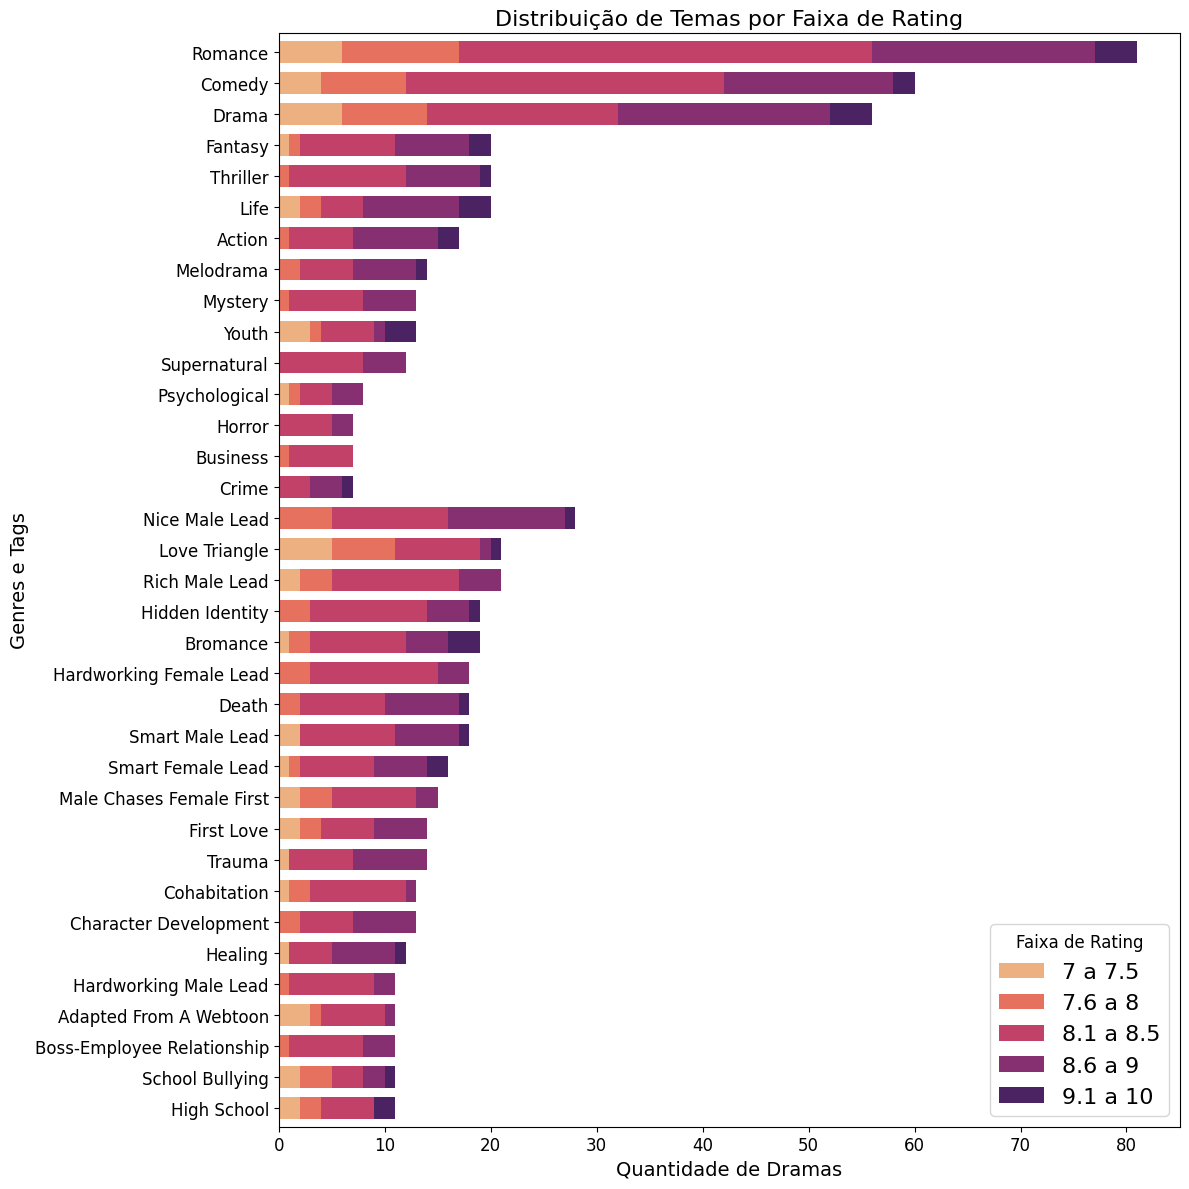

In [56]:
# Lista de variáveis qualitativas (One Hot)
variaveis = [
    'Romance', 'Comedy', 'Drama', 'Fantasy', 'Thriller', 'Life', 'Action', 'Melodrama',
    'Mystery', 'Youth', 'Supernatural', 'Psychological', 'Horror', 'Business', 'Crime',
    'Nice Male Lead', 'Love Triangle', 'Rich Male Lead', 'Hidden Identity', 'Bromance',
    'Hardworking Female Lead', 'Death', 'Smart Male Lead', 'Smart Female Lead',
    'Male Chases Female First', 'First Love', 'Trauma', 'Cohabitation', 'Character Development',
    'Healing', 'Hardworking Male Lead', 'Adapted From A Webtoon', 'Boss-Employee Relationship',
    'School Bullying', 'High School'
]

# Agrupar por faixa de rating e somar as variáveis one-hot
agrupado = drama.groupby("Rating")[variaveis].sum().T  # Transpõe para colocar variáveis no eixo Y

# Plot horizontal (barh = horizontal bars)
fig, ax = plt.subplots(figsize=(12, 12))
agrupado.plot(kind='barh', stacked=True, colormap='flare', ax=ax, width=0.7)

# Inverter eixo x para que as barras "desçam" (da direita para a esquerda)
ax.invert_yaxis()

# Estilização
ax.set_title("Distribuição de Temas por Faixa de Rating", fontsize=16)
ax.set_ylabel("Genres e Tags", fontsize=14)
ax.set_xlabel("Quantidade de Dramas", fontsize=14)
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=12)
ax.legend(title="Faixa de Rating", fontsize=16, title_fontsize=12)
plt.tight_layout()
plt.show()

**Crime** se destaca com avaliações mais altas. **Romance**, **Comedy** e **Drama** são os temas mais frequentes, possuindo K-Dramas em todas as faixas de avaliações, porém tendo maior concentração em avaliações mais medianas, entre **8.1 a 8.5**. **Business** fica um pouco abaixo dos demais, não possuindo nenhuma série com avaliação maior do que **8.5**.

## **4. Teste de Hipóteses**

Para realizar o teste de hipóteses, é interesse criar duas listas para separar as variáveis entre quantitativas e qualitativas, com o intuito de otimizar o teste.

### **4.1. Teste de hipóteses *Rating x Qualitativas***

In [57]:
remover = []

for qualitativa in quali:
  tabela = pd.crosstab(drama['Rating'], drama[qualitativa])
  qui2, p_valor, _, _ = stats.chi2_contingency(tabela)
  print(f'\nAssociação entre Rating e {qualitativa}')
  print(f'p-valor = {p_valor:.4f}')
  if p_valor < 0.05:
      print("- Existe associação significativa.")
  else:
      print("- Não há associação significativa.")
      remover.append(qualitativa)


Associação entre Rating e Rating
p-valor = 0.0000
- Existe associação significativa.

Associação entre Rating e Watchers
p-valor = 0.2632
- Não há associação significativa.

Associação entre Rating e Ep. Duration
p-valor = 0.0142
- Existe associação significativa.

Associação entre Rating e Aired On
p-valor = 0.0091
- Existe associação significativa.


Existe associação significativa para as variáveis **Ep. Duration** e **Aired On**, elas teram forte influência na rede bayesiana.

### **4.2. Teste de hipóteses *Rating x Quantitativas***

In [58]:
for quantitativa in quanti:
    grupos = [grupo[quantitativa].dropna().values for nome, grupo in drama.groupby('Rating')]
    h_stat, p_valor = stats.kruskal(*grupos)

    print(f'\nAssociação entre Rating e {quantitativa}')
    print(f'Estatística H = {h_stat:.4f}, p-valor = {p_valor:.4f}')

    if p_valor < 0.05:
        print("- Existe associação significativa (diferenças entre os grupos de Rating).")
    else:
        print("- Não há associação significativa.")
        remover.append(quantitativa)



Associação entre Rating e Year
Estatística H = 18.4475, p-valor = 0.0010
- Existe associação significativa (diferenças entre os grupos de Rating).

Associação entre Rating e Episodes
Estatística H = 5.6151, p-valor = 0.2298
- Não há associação significativa.

Associação entre Rating e Romance
Estatística H = 13.0273, p-valor = 0.0111
- Existe associação significativa (diferenças entre os grupos de Rating).

Associação entre Rating e Comedy
Estatística H = 6.2321, p-valor = 0.1825
- Não há associação significativa.

Associação entre Rating e Drama
Estatística H = 10.4767, p-valor = 0.0331
- Existe associação significativa (diferenças entre os grupos de Rating).

Associação entre Rating e Fantasy
Estatística H = 1.2447, p-valor = 0.8707
- Não há associação significativa.

Associação entre Rating e Thriller
Estatística H = 3.1867, p-valor = 0.5271
- Não há associação significativa.

Associação entre Rating e Life
Estatística H = 7.4925, p-valor = 0.1120
- Não há associação significativa.

<ipython-input-58-bec9638a5663>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grupos = [grupo[quantitativa].dropna().values for nome, grupo in drama.groupby('Rating')]



Associação entre Rating e Psychological
Estatística H = 1.3905, p-valor = 0.8459
- Não há associação significativa.

Associação entre Rating e Horror
Estatística H = 3.0899, p-valor = 0.5429
- Não há associação significativa.

Associação entre Rating e Business
Estatística H = 6.3733, p-valor = 0.1730
- Não há associação significativa.

Associação entre Rating e Crime
Estatística H = 2.1085, p-valor = 0.7158
- Não há associação significativa.

Associação entre Rating e Nice Male Lead
Estatística H = 5.4353, p-valor = 0.2455
- Não há associação significativa.

Associação entre Rating e Love Triangle
Estatística H = 27.7967, p-valor = 0.0000
- Existe associação significativa (diferenças entre os grupos de Rating).

Associação entre Rating e Rich Male Lead
Estatística H = 5.0579, p-valor = 0.2814
- Não há associação significativa.

Associação entre Rating e Hidden Identity
Estatística H = 3.8663, p-valor = 0.4244
- Não há associação significativa.

Associação entre Rating e Bromance
Esta

Existe associação significativa para as variáveis **Year**, **Romance**, **Drama**, **Youth**, **Love Triangle**, **Adapted From a Webtoon** e **High School**, elas teram forte influência na rede bayesiana.

### **4.3. Removendo colunas sem associação significativa**

In [59]:
for coluna in remover:
    drama.drop(columns=[coluna], inplace=True)

In [60]:
drama.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   Name                    100 non-null    object  
 1   Year                    100 non-null    int64   
 2   Rating                  100 non-null    category
 3   Ep. Duration            100 non-null    category
 4   Aired On                100 non-null    object  
 5   Romance                 100 non-null    int64   
 6   Drama                   100 non-null    int64   
 7   Youth                   100 non-null    int64   
 8   Love Triangle           100 non-null    int64   
 9   Adapted From A Webtoon  100 non-null    int64   
 10  High School             100 non-null    int64   
dtypes: category(2), int64(7), object(2)
memory usage: 7.8+ KB


## **5. Rede Bayesiana**

### **5.1. Grafo da Rede Bayesiana**

Construindo a **Rede Bayesiana** utilizando as informações obtidas no teste de hipóteses realizado:

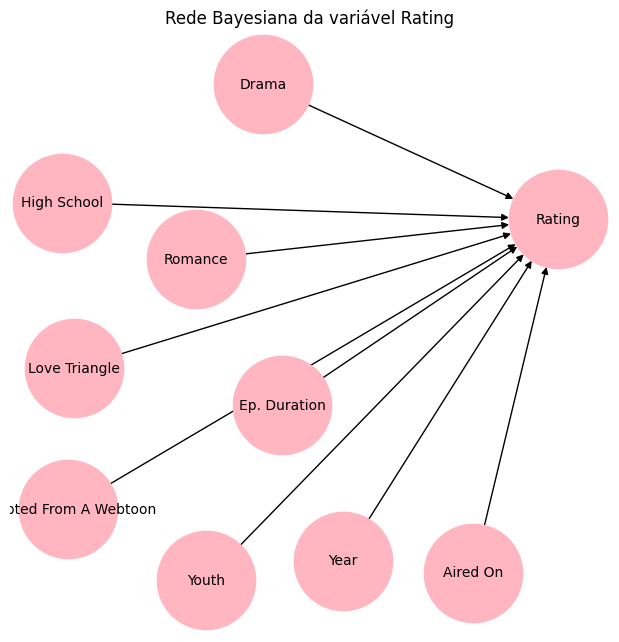

In [61]:
estrutura = DiscreteBayesianNetwork([
    ("Year", "Rating"),
    ("Ep. Duration", "Rating"),
    ("Aired On", "Rating"),
    ("Romance", "Rating"),
    ("Drama", "Rating"),
    ("Youth", "Rating"),
    ("Love Triangle", "Rating"),
    ("Adapted From A Webtoon", "Rating"),
    ("High School", "Rating")
])

grafo = nx.DiGraph()
edges = estrutura.edges()
grafo.add_edges_from(edges)

plt.figure(figsize=(6, 6))
nx.draw(grafo, with_labels = True, node_color = 'lightpink', edge_color = 'black', node_size = 5000, font_size = 10)
plt.title("Rede Bayesiana da variável Rating")
plt.show()

O código define e visualiza uma **Rede Bayesiana** onde a variável Rating é influenciada por outras variáveis como **Year, Ep. Duration, Romance, Drama,** entre outras. O grafo gerado mostra essas relações de dependência direta, representadas por setas apontando para **Rating**, o que indica que ela é a variável-alvo da análise.

### **5.2. Estimador Bayesiano**

In [62]:
estrutura.fit(drama, estimator = BayesianEstimator)
for cpd in estrutura.get_cpds():
    print(cpd)

+------------+-----------+
| Year(2007) | 0.0125    |
+------------+-----------+
| Year(2009) | 0.0220238 |
+------------+-----------+
| Year(2010) | 0.0220238 |
+------------+-----------+
| Year(2011) | 0.0220238 |
+------------+-----------+
| Year(2013) | 0.0410714 |
+------------+-----------+
| Year(2014) | 0.0410714 |
+------------+-----------+
| Year(2015) | 0.060119  |
+------------+-----------+
| Year(2016) | 0.145833  |
+------------+-----------+
| Year(2017) | 0.0982143 |
+------------+-----------+
| Year(2018) | 0.0505952 |
+------------+-----------+
| Year(2019) | 0.107738  |
+------------+-----------+
| Year(2020) | 0.13631   |
+------------+-----------+
| Year(2021) | 0.0982143 |
+------------+-----------+
| Year(2022) | 0.0791667 |
+------------+-----------+
| Year(2023) | 0.0410714 |
+------------+-----------+
| Year(2024) | 0.0220238 |
+------------+-----------+
+------------------------+-----+-------------------------------+
| Adapted From A Webtoon | ... | Adapted Fro

Assim, foi realizado o ajuste na **Rede Bayesiana** com base nos dados e na probabilidade de cada variável assumir.

### **5.3. Predição da variável *Rating***

In [63]:
teste = drama.sample(5)
display(teste)

,Name,Year,Rating,Ep. Duration,Aired On,Romance,Drama,Youth,Love Triangle,Adapted From A Webtoon,High School
25,My ID is Gangnam Beauty,2018,7.6 a 8,00:51 a 00:60,"Friday, Saturday",1,1,1,0,1,0
37,Sweet Home,2020,8.6 a 9,00:51 a 00:60,Friday,0,1,0,0,1,0
38,Romance Is a Bonus Book,2019,8.1 a 8.5,00:61 a 00:70,"Saturday, Sunday",1,0,0,1,0,0
49,Touch Your Heart,2019,8.1 a 8.5,00:61 a 00:70,"Wednesday, Thursday",1,1,0,0,0,0
20,Pinocchio,2014,8.1 a 8.5,00:51 a 00:60,"Wednesday, Thursday",1,0,0,0,0,0


In [69]:
inferencia = VariableElimination(estrutura)

predicoes = []
for index, row in teste.iterrows():
    dados_inferencia = {
        'Year': row['Year'],
        'Ep. Duration': row['Ep. Duration'],
        'Aired On': row['Aired On'],
        'Romance': row['Romance'],
        'Drama': row['Drama'],
        'Youth': row['Youth'],
        'Love Triangle': row['Love Triangle'],
        'Adapted From A Webtoon': row['Adapted From A Webtoon'],
        'High School': row['High School']
    }

    predicao_rating = inferencia.query(variables=['Rating'], evidence=dados_inferencia)
    predicoes.append(predicao_rating)

for i, pred in enumerate(predicoes):
    print(f"Predição {teste['Name'].iloc[i]}:")
    print(pred)
    print(f"Valor real: {teste['Rating'].iloc[i]}\n")

Predição My ID is Gangnam Beauty:
+-------------------+---------------+
| Rating            |   phi(Rating) |
+===================+===============+
| Rating(7 a 7.5)   |        0.0000 |
+-------------------+---------------+
| Rating(7.6 a 8)   |        0.9999 |
+-------------------+---------------+
| Rating(8.1 a 8.5) |        0.0000 |
+-------------------+---------------+
| Rating(8.6 a 9)   |        0.0000 |
+-------------------+---------------+
| Rating(9.1 a 10)  |        0.0000 |
+-------------------+---------------+
Valor real: 7.6 a 8

Predição Sweet Home:
+-------------------+---------------+
| Rating            |   phi(Rating) |
+===================+===============+
| Rating(7 a 7.5)   |        0.0000 |
+-------------------+---------------+
| Rating(7.6 a 8)   |        0.0000 |
+-------------------+---------------+
| Rating(8.1 a 8.5) |        0.0000 |
+-------------------+---------------+
| Rating(8.6 a 9)   |        0.9999 |
+-------------------+---------------+
| Rating(9.1

O código realiza a inferência da variável **Rating** para cada drama do conjunto de teste, utilizando as evidências fornecidas pelas demais variáveis. Com base na rede bayesiana previamente treinada, o modelo foi capaz de prever corretamente todos os valores de **Rating**, atingindo **100% de acerto** nas predições.